In [1]:
'''
when preparing train data, open the original image file(nd2), check the label and its corresponding cell
'''

'\nwhen preparing train data, open the original image file(nd2), check the label and its corresponding cell\n'

In [3]:
import numpy as np
from skimage.segmentation import watershed,clear_border
import scipy.misc
from skimage.io import imread
from matplotlib import pyplot as plt
import scipy.ndimage as ndi
import pickle
import os
from os import listdir
from skimage.feature import peak_local_max
from skimage.morphology import remove_small_objects,local_maxima,h_maxima
from skimage.measure import regionprops,label
from skimage.color import label2rgb
from PIL import Image, ImageDraw, ImageFont
from math import pi

In [128]:
main_path='/home/zoro/Desktop/experiment_data/2019-03-22_a549_tgf4ng_2d/'
output_path=main_path+'output/'
posi_end=3

crop_path=main_path+'crop_am/'

In [5]:
def color_num(labels):
    label_rgb=label2rgb(labels,bg_label=0)
    img_rgb= scipy.misc.toimage(label_rgb)
    base = img_rgb.convert('RGBA')
    # make a blank image for the text, initialized to transparent text color
    txt = Image.new('RGBA', base.size, (255,255,255,0))
    # get a font
    fnt = ImageFont.truetype('arial.ttf', 60)
    # get a drawing context
    d = ImageDraw.Draw(txt)
    for region in regionprops(labels):
        cx=int(region.centroid[1])     
        cy=int(region.centroid[0])
        d.text((cx,cy),str(labels[cy][cx]),font=fnt,fill=(255,255,255,255)) 
    out = Image.alpha_composite(base, txt)       
    #out.show()
    #out.save(path_rgb_num+'/'+img_name+'.png', "PNG")
    return out

In [22]:
local_h_thres=0.05#should be small enough to seg small cells 
small_obj_thres=1500#for clear small dots
mask_thres=0

roundness_thres=0.8
size_thres1=6000
size_thres2=10000

In [133]:
img_ind=20

#----------------markers from local h maximum--------------
for posi in range(3,posi_end+1):
    img_path=main_path+'img/'+str(posi)+'/'
    img_list = sorted(listdir(img_path))
    reg_path=output_path+str(posi)+'/reg/'
    reg_img_list = sorted(listdir(reg_path))
    
    for i in range(img_ind,img_ind+1):
        ori_img=imread(img_path+'/'+img_list[i])
        img=imread(reg_path+'/'+reg_img_list[i])
        pil_img=Image.open(img_path+'/'+img_list[i])

        local_hmax=h_maxima(img,local_h_thres)
        local_hmax_label=label(local_hmax,connectivity=1)

        labels = watershed(-img, local_hmax_label, mask=img>mask_thres)

        labels = remove_small_objects(labels, small_obj_thres)
        print np.amax(labels)
        labels= clear_border(labels)
        print np.amax(labels)
        labels=label(labels,connectivity =1)
        print np.amax(labels)

        img_name=img_list[i][0:len(img_list[i])-4]
        rgb_num=color_num(labels)


        rps=regionprops(labels)
        candi_labels=[r.label for r in rps if r.area<size_thres1 or (4*pi*r.area/r.perimeter**2>roundness_thres and r.area<size_thres2)]
        for candi_label in candi_labels:
            candi_r=[r for r in rps if r.label==candi_label][0]
            candi_box=candi_r.bbox

            re_candi_box=(candi_box[1],candi_box[0],candi_box[3],candi_box[2])#re_order the coordinates

             #tight bounding box

            candi_obj=pil_img.crop(re_candi_box)
            candi_obj.save(crop_path+'/190322_xy'+str(posi)+'_i'+str(i+1)+'_o'+str(candi_label)+'.tif')

    #-------bounding box with surrounding region---------        
    #         x_min=max(candi_box[0]-20,0)
    #         y_min=max(candi_box[1]-20,0)
    #         x_max=min(candi_box[2]+20,img_h)
    #         y_max=min(candi_box[3]+20,img_w)
    #         re_sur_box=(y_min,x_min,y_max,x_max)#surrounding box
    #         sur_obj=pil_img.crop(re_sur_box)
    #         sur_obj.save(crop_path+'/sur_xy'+posi+'_i'+str(i+1)+'_o'+str(candi_label)+'.tif')

35
35
22


/home/zoro/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  app.launch_new_instance()


[2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20]


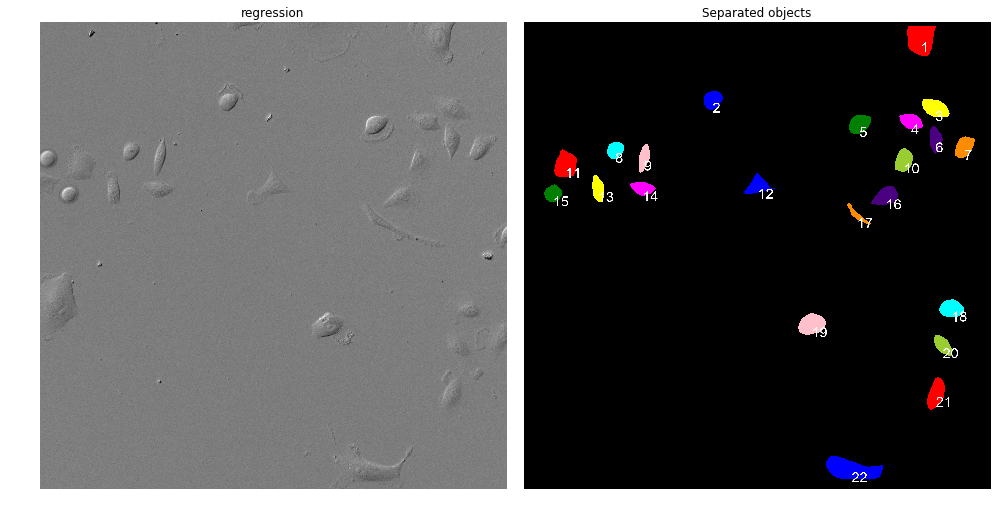

In [134]:
print(candi_labels)
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(14, 14), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()
ax[0].imshow(ori_img, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('regression')
# ax[1].imshow(img>0, cmap=plt.cm.gray, interpolation='nearest')
# ax[1].set_title('mask')

ax[1].imshow(rgb_num, cmap=plt.cm.jet, interpolation='nearest')
ax[1].set_title('Separated objects')

# ax[2].imshow(img)
# ax[2].set_title('edt')

# ax[2].imshow(img, cmap=plt.cm.gray)
# ax[2].autoscale(False)
# ax[2].plot(local_hmy[:], local_hmx[:], 'r.')#reverse order of cx and cy, because they are from skimage
# ax[2].axis('off')
# ax[2].set_title('Peak local max')

# ax[3].imshow(labels, cmap=plt.cm.jet, interpolation='nearest')
# ax[3].set_title('Separated objects')




for a in ax:
    a.set_axis_off()
fig.tight_layout()
plt.show() 

In [107]:
# #------------pick special case that is apoptosis or mitosis but do not meet the requirment of area and eccentrity
# candi_label=58
# candi_r=[r for r in rps if r.label==candi_label][0]
# candi_box=candi_r.bbox


# re_candi_box=(candi_box[1],candi_box[0],candi_box[3],candi_box[2])#re_order the coordinates

#  #tight bounding box

# candi_obj=pil_img.crop(re_candi_box)
# candi_obj.save(crop_path+'/xy'+posi+'_i'+str(i+1)+'_o'+str(candi_label)+'.tif')